# Make MTH5 from IRIS Data Managment Center v0.2.0 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from mth5.mth5 import MTH5
from mth5.clients.fdsn import FDSN
from mth5.clients.make_mth5 import MakeMTH5

from matplotlib import pyplot as plt
%matplotlib inline

## Set the path to save files to as the current working directory

In [2]:
default_path = Path().cwd()
print(default_path)

c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5


## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [3]:
# FDSN object is used for instructional purposes
fdsn_object = FDSN(mth5_version='0.2.0')
fdsn_object.client = "IRIS"


## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

#### From IRIS Metadata

Here are the station running during WYYS2, the original transfer function was processed with MTF20.

| Station | Start | End |
|---------|-------|-----|
| MTF18 | 2009-07-11T00:07:55.0000 | 2009-08-28T21:31:41.0000 |
| MTF19 | 2009-07-10T00:17:16.0000 | 2009-09-16T19:39:22.0000 |
| MTF20 | 2009-07-03T22:38:13.0000 | 2009-08-13T17:15:39.0000 |
| MTF21 | 2009-07-31T21:45:22.0000 | 2009-09-18T23:56:11.0000 |
| WYI17 | 2009-07-13T22:17:15.0000 | 2009-08-04T19:41:33.0000 |
| WYI21 | 2009-07-27T07:26:00.0000 | 2009-09-11T16:36:30.0000 |
| WYJ18 | 2009-07-13T00:58:30.0000 | 2009-08-03T19:39:24.0000 |
| WYJ21 | 2009-07-23T22:23:20.0000 | 2009-08-16T21:03:53.0000 |
| WYK21 | 2009-07-22T22:01:44.0000 | 2009-08-06T12:11:52.0000 |
| WYL21 | 2009-07-21T20:27:41.0000 | 2009-08-18T17:56:39.0000 |
| WYYS1 | 2009-07-14T21:58:53.0000 | 2009-08-05T21:14:56.0000 |
| WYYS2 | 2009-07-15T22:43:28.0000 | 2009-08-20T00:17:06.0000 |

Here are the station running during WYYS3, the original transfer function was processed with MTC18

| Station | Start | End |
|---------|-------|-----|
| MTC18 | 2009-08-21T21:52:53.0000 | 2009-09-13T00:02:18.0000 | 
| MTE18 | 2009-08-07T20:40:38.0000 | 2009-08-28T19:03:01.0000 | 
| MTE19 | 2009-08-12T22:45:47.0000 | 2009-09-02T17:10:53.0000 | 
| MTE20 | 2009-08-10T21:12:58.0000 | 2009-09-19T20:25:30.0000 | 
| MTE21 | 2009-08-09T02:45:02.0000 | 2009-08-30T21:43:43.0000 | 
| WYH21 | 2009-08-01T22:50:53.0000 | 2009-08-24T20:23:03.0000 | 
| WYG21 | 2009-08-03T02:56:34.0000 | 2009-08-18T19:56:53.0000 | 
| WYYS3 | 2009-08-20T01:55:41.0000 | 2009-09-17T20:04:21.0000 |

In the examples below we will just download the original remote references, but as an excersize you could add in some other stations.

In [6]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
 
WYYS2 = ["4P", "WYYS2", "2009-07-15T00:00:00", "2009-08-21T00:00:00"]
MTF20 = ["4P", "MTF20", "2009-07-03T00:00:00", "2009-08-13T00:00:00"]
WYYS3 = ["4P", "WYYS3", "2009-08-20T00:00:00", "2009-09-17T00:00:00"]
MTC18 = ["4P", "MTC20", "2009-08-21T00:00:00", "2009-09-13T00:00:00"]

request_list = []
for entry in [WYYS2, MTF20, WYYS3, MTC18]:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_object.request_columns) 
request_df

,network,station,location,channel,start,end
0,4P,WYYS2,,LFE,2009-07-15T00:00:00,2009-08-21T00:00:00
1,4P,WYYS2,,LFN,2009-07-15T00:00:00,2009-08-21T00:00:00
2,4P,WYYS2,,LFZ,2009-07-15T00:00:00,2009-08-21T00:00:00
3,4P,WYYS2,,LQE,2009-07-15T00:00:00,2009-08-21T00:00:00
4,4P,WYYS2,,LQN,2009-07-15T00:00:00,2009-08-21T00:00:00
5,4P,MTF20,,LFE,2009-07-03T00:00:00,2009-08-13T00:00:00
6,4P,MTF20,,LFN,2009-07-03T00:00:00,2009-08-13T00:00:00
7,4P,MTF20,,LFZ,2009-07-03T00:00:00,2009-08-13T00:00:00
8,4P,MTF20,,LQE,2009-07-03T00:00:00,2009-08-13T00:00:00
9,4P,MTF20,,LQN,2009-07-03T00:00:00,2009-08-13T00:00:00


## Save the request as a CSV

Its helpful to be able to save the request as a CSV and modify it and use it later.  A CSV can be input as a request to `MakeMTH5`

In [5]:
request_df.to_csv(default_path.joinpath("fdsn_request.csv"))

## Get only the metadata from IRIS

It can be helpful to make sure that your request is what you would expect.  For that you can request only the metadata from IRIS.  The request is quick and light so shouldn't need to worry about the speed.  This returns a StationXML file and is loaded into an `obspy.Inventory` object.

In [6]:
inventory, data = fdsn_object.get_inventory_from_df(request_df, data=False)

/opt/conda/lib/python3.10/site-packages/mth5/clients/fdsn.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop_duplicates("station", inplace=True)
/opt/conda/lib/python3.10/site-packages/mth5/clients/fdsn.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop_duplicates("station", inplace=True)
/opt/conda/lib/python3.10/site-packages/mth5/clients/fdsn.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.

Have a look at the Inventory to make sure it contains what is requested.

In [7]:
inventory.write(default_path.joinpath("yellowstone_stationxml.xml").as_posix(), format="stationxml")
print(inventory)

Inventory created at 2024-09-20T00:40:31.940624Z
	Created by: ObsPy 1.4.1
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (4):
			4P (4x)
		Stations (4):
			4P.MTC20 (Zortman, MT, USA)
			4P.MTF20 (Billings, MT, USA)
			4P.WYYS2 (Grant Village, WY, USA)
			4P.WYYS3 (Fishing Bridge, WY, USA)
		Channels (26):
			4P.MTC20..LFZ, 4P.MTC20..LFN, 4P.MTC20..LFE, 4P.MTC20..LQN, 
			4P.MTC20..LQE, 4P.MTF20..LFZ, 4P.MTF20..LFN (2x), 
			4P.MTF20..LFE (2x), 4P.MTF20..LQN (2x), 4P.MTF20..LQE (2x), 
			4P.WYYS2..LFZ, 4P.WYYS2..LFN, 4P.WYYS2..LFE, 4P.WYYS2..LQN, 
			4P.WYYS2..LQE, 4P.WYYS3..LFZ, 4P.WYYS3..LFN, 4P.WYYS3..LFE, 
			4P.WYYS3..LQN (2x), 4P.WYYS3..LQE (2x)


## Make an MTH5 from a request

Now that we've created a request, and made sure that its what we expect, we can make an MTH5 file.  The input can be either the DataFrame or the CSV file.

Here we are going to use the `MakeMTH5` object to create from an FDSN client.  

We are going to time it just to get an indication how long it might take.  Should take a couple of minutes depending on connection.

<div class="alert alert-block alert-info">
<b>Note:</b> We are setting `interact=False`.  If you want to just to keep the file open to interogat it set `interact=True`. 
</div> 

In [7]:
%%time

mth5_object = MakeMTH5.from_fdsn_client(request_df, interact=False)

print(f"Created {mth5_object}")

2024-10-14T14:35:37.707606-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\iris-mt-course-2022\notebooks\mth5\4P_WYYS2_MTF20_WYYS3_MTC20.h5 in mode w


C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\clients\fdsn.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop_duplicates("station", inplace=True)
C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\clients\fdsn.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop_duplicates("station", inplace=True)
C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\mth5\clients\fdsn.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

2024-10-14T14:39:35.090107-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-10-14T14:39:35.131113-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_100.000 to a CoefficientFilter.
2024-10-14T14:39:35.375772-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-10-14T14:39:35.415768-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_100.000 to a CoefficientFilter.
2024-10-14T14:39:36.030731-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-10-14T14:39:36.052718-0700 | INFO

In [8]:
# open file already created
mth5_object = MTH5()
mth5_object = mth5_object.open_mth5("4P_WYYS2_MTF20_WYYS3_MTC20.h5")

## Have a look at the contents of the created file

In [10]:
mth5_object

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: 4P
            ------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: electric_analog_to_digital
                        ------------------------------------
                        |- Group: electric_dipole_100.000
                        ---------------------------------
                        |- Group: electric_si_units
                        ---------------------------
                        |- Group: magnetic_analog_to_digital
                        ------------------------------------
                    |- Group: fap
                   

## Channel Summary

A convenience table is supplied with an MTH5 file.  This table provides some information about each channel that is present in the file.  It also provides columns `hdf5_reference`, `run_hdf5_reference`, and `station_hdf5_reference`, these are internal references within an HDF5 file and can be used to directly access a group or dataset by using `mth5_object.from_reference` method.  

**Note:** When a MTH5 file is close the table is resummarized so when you open the file next the `channel_summary` will be up to date. Same with the `tf_summary`.

In [9]:
mth5_object.channel_summary.clear_table()
mth5_object.channel_summary.summarize()

ch_df = mth5_object.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,4P,MTC20,a,47.75520,-108.000,833.447772,ex,2009-08-22 23:54:15+00:00,2009-08-23 01:04:36+00:00,4222,1.0,electric,11.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,4P,MTC20,a,47.75520,-108.000,833.447772,ey,2009-08-22 23:54:15+00:00,2009-08-23 01:04:36+00:00,4222,1.0,electric,101.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,4P,MTC20,a,47.75520,-108.000,833.447772,hx,2009-08-22 23:54:15+00:00,2009-08-23 01:04:36+00:00,4222,1.0,magnetic,11.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,4P,MTC20,a,47.75520,-108.000,833.447772,hy,2009-08-22 23:54:15+00:00,2009-08-23 01:04:36+00:00,4222,1.0,magnetic,101.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,4P,MTC20,a,47.75520,-108.000,833.447772,hz,2009-08-22 23:54:15+00:00,2009-08-23 01:04:36+00:00,4222,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,4P,MTC20,b,47.75520,-108.000,833.447772,ex,2009-08-23 01:33:26+00:00,2009-09-01 18:50:07+00:00,839802,1.0,electric,11.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,4P,MTC20,b,47.75520,-108.000,833.447772,ey,2009-08-23 01:33:26+00:00,2009-09-01 18:50:07+00:00,839802,1.0,electric,101.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,4P,MTC20,b,47.75520,-108.000,833.447772,hx,2009-08-23 01:33:26+00:00,2009-09-01 18:50:07+00:00,839802,1.0,magnetic,11.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,4P,MTC20,b,47.75520,-108.000,833.447772,hy,2009-08-23 01:33:26+00:00,2009-09-01 18:50:07+00:00,839802,1.0,magnetic,101.8,0.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,4P,MTC20,b,47.75520,-108.000,833.447772,hz,2009-08-23 01:33:26+00:00,2009-09-01 18:50:07+00:00,839802,1.0,magnetic,0.0,90.0,digital counts,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Run Summary

Have a look at the run summary.

In [10]:
mth5_object.run_summary

,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",4221.0,2009-08-23 01:04:36+00:00,True,"[hx, hy]",None,4222,"[ex, ey, hz]",a,1.0,2009-08-22 23:54:15+00:00,MTC20,4P,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",839801.0,2009-09-01 18:50:07+00:00,True,"[hx, hy]",None,839802,"[ex, ey, hz]",b,1.0,2009-08-23 01:33:26+00:00,MTC20,4P,<HDF5 object reference>,<HDF5 object reference>
2,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",967984.0,2009-09-13 00:00:00+00:00,True,"[hx, hy]",None,967985,"[ex, ey, hz]",c,1.0,2009-09-01 19:06:56+00:00,MTC20,4P,<HDF5 object reference>,<HDF5 object reference>
3,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",7539.0,2009-07-04 00:43:52+00:00,True,"[hx, hy]",None,7540,"[ex, ey, hz]",a,1.0,2009-07-03 22:38:13+00:00,MTF20,4P,<HDF5 object reference>,<HDF5 object reference>
4,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2400660.0,2009-07-31 19:39:01+00:00,True,"[hx, hy]",None,2400661,"[ex, ey, hz]",b,1.0,2009-07-04 00:48:01+00:00,MTF20,4P,<HDF5 object reference>,<HDF5 object reference>
5,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1048353.0,2009-08-13 00:00:00+00:00,True,"[hx, hy]",None,1048354,"[ex, ey, hz]",c,1.0,2009-07-31 20:47:27+00:00,MTF20,4P,<HDF5 object reference>,<HDF5 object reference>
6,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",2833.0,2009-07-15 23:30:41+00:00,True,"[hx, hy]",None,2834,"[ex, ey, hz]",a,1.0,2009-07-15 22:43:28+00:00,WYYS2,4P,<HDF5 object reference>,<HDF5 object reference>
7,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1798232.0,2009-08-05 19:09:39+00:00,True,"[hx, hy]",None,1798233,"[ex, ey, hz]",b,1.0,2009-07-15 23:39:07+00:00,WYYS2,4P,<HDF5 object reference>,<HDF5 object reference>
8,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",1225635.0,2009-08-20 00:17:06+00:00,True,"[hx, hy]",None,1225636,"[ex, ey, hz]",c,1.0,2009-08-05 19:49:51+00:00,WYYS2,4P,<HDF5 object reference>,<HDF5 object reference>
9,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",746884.0,2009-08-28 17:23:45+00:00,True,"[hx, hy]",None,746885,"[ex, ey, hz]",c,1.0,2009-08-20 01:55:41+00:00,WYYS3,4P,<HDF5 object reference>,<HDF5 object reference>


## Have a look at a station

Lets grab one station `CAS04` and have a look at its metadata and contents.
Here we will grab it from the `mth5_object`.

In [12]:
wyys2 = mth5_object.get_station("WYYS2", survey="4P")
wyys2.metadata

{
    "station": {
        "acquired_by.name": null,
        "channels_recorded": [
            "ex",
            "ey",
            "hx",
            "hy",
            "hz"
        ],
        "data_type": "MT",
        "fdsn.id": "WYYS2",
        "geographic_name": "Grant Village, WY, USA",
        "hdf5_reference": "<HDF5 object reference>",
        "id": "WYYS2",
        "location.declination.comments": "igrf.m by Drew Compston",
        "location.declination.model": "IGRF-13",
        "location.declination.value": 12.5095194946954,
        "location.elevation": 2392.334716797,
        "location.latitude": 44.39635,
        "location.longitude": -110.577,
        "mth5_type": "Station",
        "orientation.method": "compass",
        "orientation.reference_frame": "geographic",
        "provenance.archive.name": null,
        "provenance.creation_time": "1980-01-01T00:00:00+00:00",
        "provenance.creator.name": null,
        "provenance.software.author": "Anna Kelbert, USGS",
 

### Changing Metadata
If you want to change the metadata of any group, be sure to use the `write_metadata` method.  Here's an example:

In [13]:
wyys2.metadata.location.declination.value = 12.2
wyys2.write_metadata()
print(wyys2.metadata.location.declination)

declination:
	comments = igrf.m by Drew Compston
	model = IGRF-13
	value = 12.2


## Have a look at a single channel

Let's pick out a channel and interogate it. There are a couple ways
1. Get a channel the first will be from the `hdf5_reference` [*demonstrated here*]
2. Get a channel from `mth5_object`
3. Get a station first then get a channel


In [14]:
ex = mth5_object.from_reference(ch_df.iloc[50].hdf5_reference).to_channel_ts()
print(ex)

Channel Summary:
	Survey:       4P
	Station:      WYYS3
	Run:          c
	Channel Type: Magnetic
	Component:    hz
	Sample Rate:  1.0
	Start:        2009-08-20T01:55:41+00:00
	End:          2009-08-28T17:23:45+00:00
	N Samples:    746885


In [15]:
ex.channel_metadata

{
    "magnetic": {
        "channel_number": 0,
        "comments": "run_ids: [d,c]",
        "component": "hz",
        "data_quality.rating.value": 0,
        "filter.applied": [
            true,
            true,
            true
        ],
        "filter.name": [
            "magnetic_butterworth_low_pass",
            "magnetic_analog_to_digital",
            "hz_time_offset"
        ],
        "hdf5_reference": "<HDF5 object reference>",
        "location.elevation": 2379.8,
        "location.latitude": 44.5607,
        "location.longitude": -110.315,
        "measurement_azimuth": 0.0,
        "measurement_tilt": 90.0,
        "mth5_type": "Magnetic",
        "sample_rate": 1.0,
        "sensor.id": "2612-18",
        "sensor.manufacturer": "Barry Narod",
        "sensor.model": "fluxgate NIMS",
        "sensor.name": "NIMS",
        "sensor.type": "Magnetometer",
        "time_period.end": "2009-08-28T17:23:45+00:00",
        "time_period.start": "2009-08-20T01:55:41+00:00",

## Calibrate time series data
Most data loggers output data in digital counts.  Then a series of filters that represent the various instrument responses are applied to get the data into physical units.  The data can then be analyzed and processed. Commonly this is done during the processing step, but it is important to be able to look at time series data in physical units.  Here we provide a `remove_instrument_response` method in the `ChananelTS` object.  Here's an example:  

Filters Included:
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = NIMS magnetic field 3 pole Butterworth 0.5 low pass (analog)
	gain = 1.0
	name = magnetic_butterworth_low_pass
	normalization_factor = 2002.26936395594
	poles = [ -6.283185+10.882477j  -6.283185-10.882477j -12.566371 +0.j      ]
	type = zpk
	units_in = nT
	units_out = V
	zeros = []
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = analog to digital conversion (magnetic)
	gain = 100.0
	name = magnetic_analog_to_digital
	type = coefficient
	units_in = V
	units_out = count
--------------------
time_delay_filter:
	calibration_date = 1980-01-01
	comments = time offset in seconds (digital)
	delay = -0.21
	gain = 1.0
	name = hz_time_offset
	type = time delay
	units_in = count
	units_out = count
--------------------

2024-09-19T17:44:25.205420-0700 | WARNING | mt_metadata.timeseries.filters.channel_response | complex_response | Filters list not provided, building list assuming all a

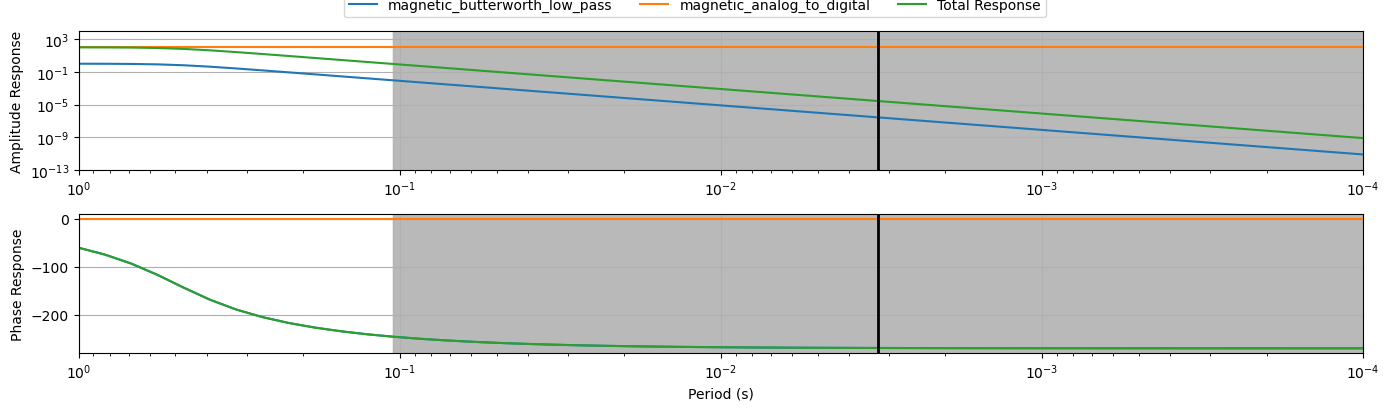

In [16]:
print(ex.channel_response)
ex.channel_response.plot_response(np.logspace(0, 4, 50))

/opt/conda/lib/python3.10/site-packages/mth5/timeseries/ts_filters.py:546: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim((f[0], f[-1]))


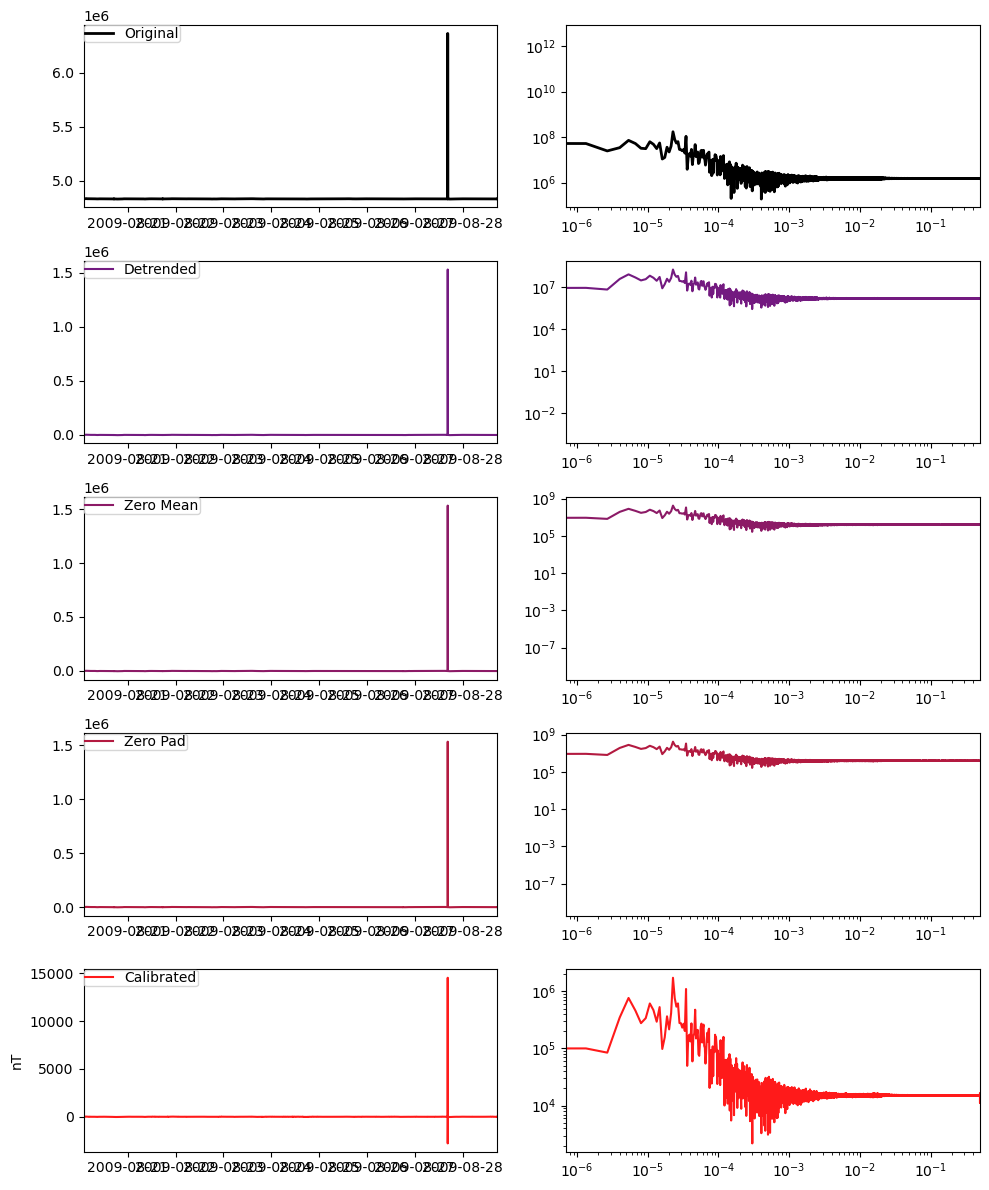

Channel Summary:
	Survey:       4P
	Station:      WYYS3
	Run:          c
	Channel Type: Magnetic
	Component:    hz
	Sample Rate:  1.0
	Start:        2009-08-20T01:55:41+00:00
	End:          2009-08-28T17:23:45+00:00
	N Samples:    746885

In [17]:
ex.remove_instrument_response(plot=True)

## Have a look at a run

Let's pick out a run, take a slice of it, and interogate it. There are a couple ways
1. Get a run the first will be from the `run_hdf5_reference` [*demonstrated here*]
2. Get a run from `mth5_object`
3. Get a station first then get a run

In [18]:
run_from_reference = mth5_object.from_reference(ch_df.iloc[0].run_hdf5_reference).to_runts(start=ch_df.iloc[0].start.isoformat(), n_samples=360)
print(run_from_reference)

2024-09-19T17:44:31.517989-0700 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2009-08-23T00:00:14+00:00 does not match metadata end 2009-08-23T01:04:36+00:00 updating metatdata value to 2009-08-23T00:00:14+00:00
RunTS Summary:
	Survey:      4P
	Station:     MTC20
	Run:         a
	Start:       2009-08-22T23:54:15+00:00
	End:         2009-08-23T00:00:14+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy', 'hz']


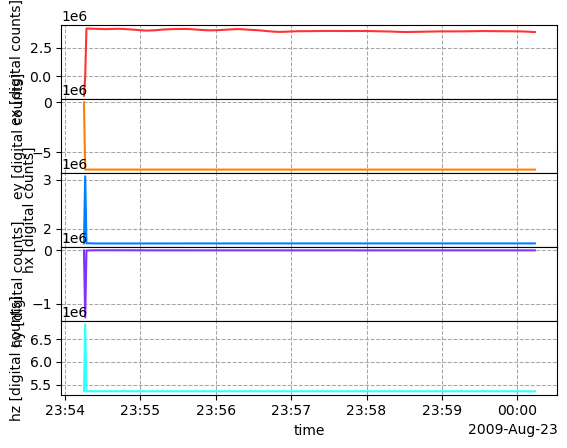

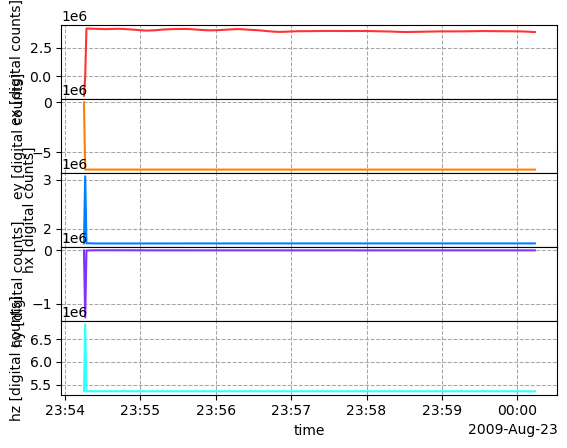

In [19]:
run_from_reference.plot()

### Calibrate Run

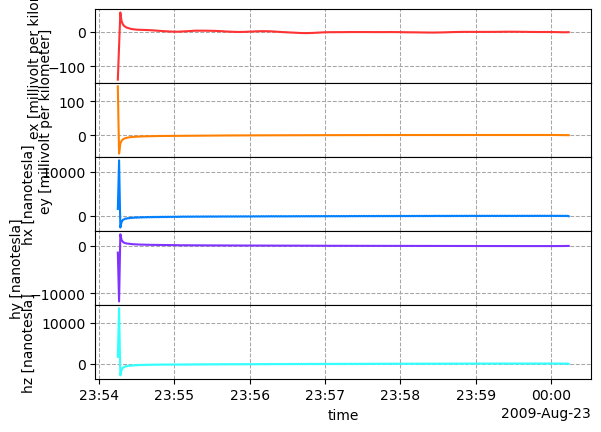

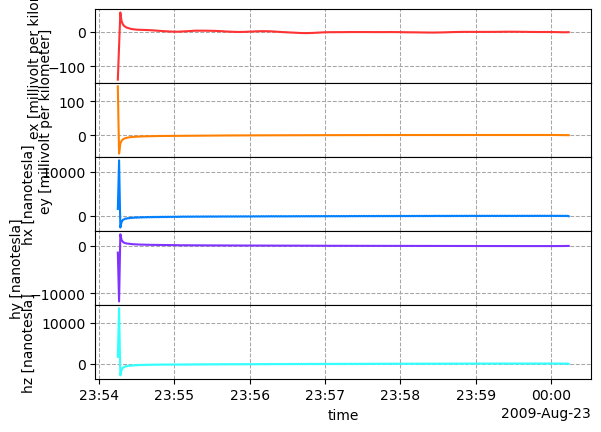

In [20]:
calibrated_run = run_from_reference.calibrate()
calibrated_run.plot()

## Load Transfer Functions

You can download the transfer functions from [IRIS SPUD EMTF](http://ds.iris.edu/spud/emtf).  This has already been done as EMTF XML format and will be loaded here. 

Note that there are some discrepencies between metadata in the time series data and the transfer functions.  For now we will leave it as it is, because that's the way it is stored at IRIS, but if you really wanted to be careful you would comb through the differences and choose which one is the most correct.  This is a good example of how handling metadata can be a messy job.

In [21]:
tf_path = default_path.parent.parent.joinpath("data","transfer_functions","earthscope")
tf_list = [tf_path.joinpath(f"USArray.{station}.2009.xml") for station in ["WYYS2", "WYYS3"]]

In [22]:
from mt_metadata.transfer_functions.core import TF

In [23]:
for tf_fn in tf_list:
    tf_object = TF(tf_fn)
    tf_object.read()
    
    # update run id and add new run if needed
    for ii, run_id in enumerate(tf_object.station_metadata.transfer_function.runs_processed):
        try:
            tf_object.station_metadata.runs[ii].id = run_id
        except IndexError:
            new_run = deepcopy(tf_object.station_metadata.runs[0])
            new_run.id = run_id
            tf_object.station_metadata.add_run(new_run)
            
    mth5_object.add_transfer_function(tf_object)

2024-09-19T17:44:37.243150-0700 | WARNING | mth5.mth5 | get_survey | /Experiment/Surveys/Transportable_Array does not exist, check survey_list for existing names.


### Have a look at the transfer function summary

In [24]:
mth5_object.tf_summary.summarize()
tf_df = mth5_object.tf_summary.to_dataframe()
tf_df

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,WYYS2,Transportable_Array,44.39635,-110.577,2399.188,WYYS2,none,True,True,True,7.31429,18724.57,<HDF5 object reference>,<HDF5 object reference>
1,WYYS3,Transportable_Array,44.56070,-110.315,2387.725,WYYS3,none,True,True,True,7.31429,18724.57,<HDF5 object reference>,<HDF5 object reference>


## Close MTH5

We have now loaded in all the data we need for long period data.  We can now process these data using **Aurora** and have a look at the transfer functions using **MTpy**.

In [11]:
mth5_object.close_mth5()

2024-10-14T14:41:45.878984-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 4P_WYYS2_MTF20_WYYS3_MTC20.h5
